# Value Conversions
* If we want to understand what amount of additional return did a variant gave us, we cannot use beta binomial model
* Revenue Generated can be a calculation of Probability of paying at all * mean amount of spending while paying

In [1]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import bernoulli, expon

In [2]:
# Setting the random seed
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

plotting_defaults = dict(bins=50, kind="hist", textsize=10)

In [3]:
# Defining the dataclass BetaPrior and BinomialData 
@dataclass
class BetaPrior:
    alpha: float
    beta: float

@dataclass
class BinomialData:
    trials: int
    successes: int

@dataclass
class GammaPrior:
    alpha: float
    beta: float

In [4]:
@dataclass
class RevenueData:
    visitors: int
    purchased: int
    total_revenue: float

In [5]:
class RevenueModel:
    def __init__(self, conversion_rate_prior: BetaPrior, mean_purchase_prior: GammaPrior):
        self.conversion_rate_prior = conversion_rate_prior
        self.mean_purchase_prior = mean_purchase_prior

    def create_model(self, data: List[RevenueData], comparison_method: str) -> pm.Model:
        num_variants = len(data)
        visitors = [d.visitors for d in data]
        purchased = [d.purchased for d in data]
        total_revenue = [d.total_revenue for d in data]

        with pm.Model() as model:
            theta = pm.Beta(
                "theta",
                alpha=self.conversion_rate_prior.alpha,
                beta=self.conversion_rate_prior.beta,
                shape=num_variants,
            )

            lam = pm.Gamma(
                            "lam",
                            alpha=self.mean_purchase_prior.alpha,
                            beta=self.mean_purchase_prior.beta,
                            shape=num_variants,
            )

            # Likelihood 
            converted = pm.Binomial(
                "converted", n=visitors, p=theta, observed=purchased, shape=num_variants
            )
            revenue = pm.Gamma(
                "revenue", alpha=purchased, beta=lam, observed=total_revenue, shape=num_variants
            )
            revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta * (1 / lam))
            theta_reluplift = []
            reciprocal_lam_reluplift = []
            reluplift = []

            for i in range(num_variants):
                if comparison_method == "compare_to_control":
                    comparison_theta = theta[0]
                    comparison_lam = 1 / lam[0]
                    comparison_rpv = revenue_per_visitor[0]
                elif comparison_method == "best_of_rest":
                    others_theta = [theta[j] for j in range(num_variants) if j != i]
                    others_lam = [1 / lam[j] for j in range(num_variants) if j != i]
                    others_rpv = [revenue_per_visitor[j] for j in range(num_variants) if j != i]
                    if len(others_rpv) > 1:
                        comparison_theta = pm.math.maximum(*others_theta)
                        comparison_lam = pm.math.maximum(*others_lam)
                        comparison_rpv = pm.math.maximum(*others_rpv)
                    else:
                        comparison_theta = others_theta[0]
                        comparison_lam = others_lam[0]
                        comparison_rpv = others_rpv[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")

                theta_reluplift.append(
                    pm.Deterministic(f"theta_reluplift_{i}", theta[i] / comparison_theta - 1)
                )
                reciprocal_lam_reluplift.append(
                    pm.Deterministic(
                        f"reciprocal_lam_reluplift_{i}", (1 / lam[i]) / comparison_lam - 1
                    )
                )
                reluplift.append(
                    pm.Deterministic(f"reluplift_{i}", revenue_per_visitor[i] / comparison_rpv - 1)
                )
        return model

In [6]:
c_prior = BetaPrior(alpha=5000, beta=5000)
mp_prior = GammaPrior(alpha=9000, beta=900)

In [7]:
data = [
    RevenueData(visitors=1, purchased=1, total_revenue=1),
    RevenueData(visitors=1, purchased=1, total_revenue=1),
]

In [8]:
with RevenueModel(c_prior, mp_prior).create_model(data, "best_of_rest") as model:
    revenue_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

Sampling: [converted, lam, revenue, theta]


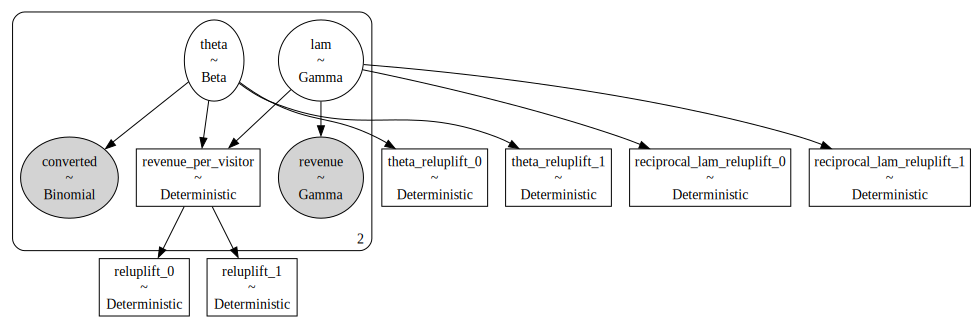

In [9]:
# Visualization of the model
pm.model_to_graphviz(model)

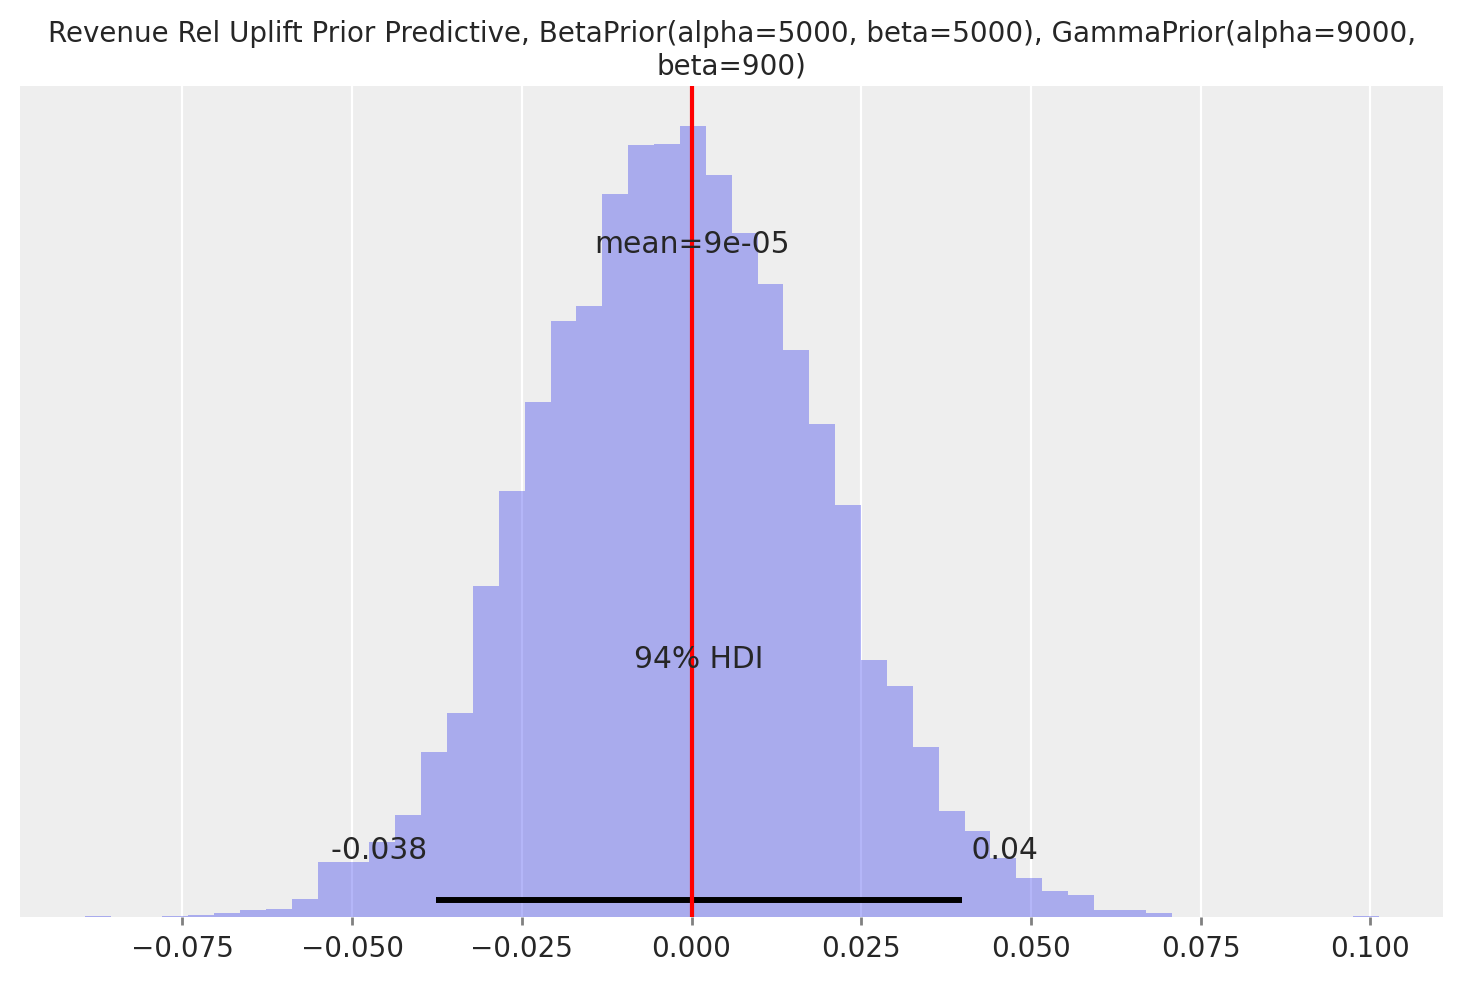

In [10]:
fig, ax = plt.subplots()
az.plot_posterior(revenue_prior_predictive["reluplift_1"], ax=ax, **plotting_defaults)
ax.set_title(f"Revenue Rel Uplift Prior Predictive, {c_prior}, {mp_prior}", fontsize=10)
ax.axvline(x=0, color="red");

In [11]:
def generate_revenue_data(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int,
) -> pd.DataFrame:
    converted = {}
    mean_purchase = {}
    for variant, p, mp in zip(variants, true_conversion_rates, true_mean_purchase):
        converted[variant] = bernoulli.rvs(p, size=samples_per_variant)
        mean_purchase[variant] = expon.rvs(scale=mp, size=samples_per_variant)
    converted = pd.DataFrame(converted)
    mean_purchase = pd.DataFrame(mean_purchase)
    revenue = converted * mean_purchase
    agg = pd.concat(
        [
            converted.aggregate(["count", "sum"]).rename(
                index={"count": "visitors", "sum": "purchased"}
            ),
            revenue.aggregate(["sum"]).rename(index={"sum": "total_revenue"}),
        ]
    )
    return agg

In [12]:
def run_scenario_value(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int,
    conversion_rate_prior: BetaPrior,
    mean_purchase_prior: GammaPrior,
    comparison_method: str,
) -> az.InferenceData:
    generated = generate_revenue_data(
        variants, true_conversion_rates, true_mean_purchase, samples_per_variant
    )
    data = [RevenueData(**generated[v].to_dict()) for v in variants]

    # Draw it from the posterior
    with RevenueModel(conversion_rate_prior, mean_purchase_prior).create_model(
        data, comparison_method
    ):
        trace = pm.sample(draws=5000, chains=2, cores=1)

    # Plotting 
    n_plots = len(variants)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3 * n_plots, 7), sharex=True)
    for i, variant in enumerate(variants):
        if i == 0 and comparison_method == "compare_to_control":
            axs[i].set_yticks([])
        else:
            az.plot_posterior(trace.posterior[f"reluplift_{i}"], ax=axs[i], **plotting_defaults)
        true_rpv = true_conversion_rates[i] * true_mean_purchase[i]
        axs[i].set_title(f"Rel Uplift {variant}, True RPV = {true_rpv:.2f}", fontsize=10)
        axs[i].axvline(x=0, color="red")
    fig.suptitle(f"Method {comparison_method}, {conversion_rate_prior}, {mean_purchase_prior}")

    return trace

## Scenario 1: Sme underlying purchase rate and mean purchase value

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, lam]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 9 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


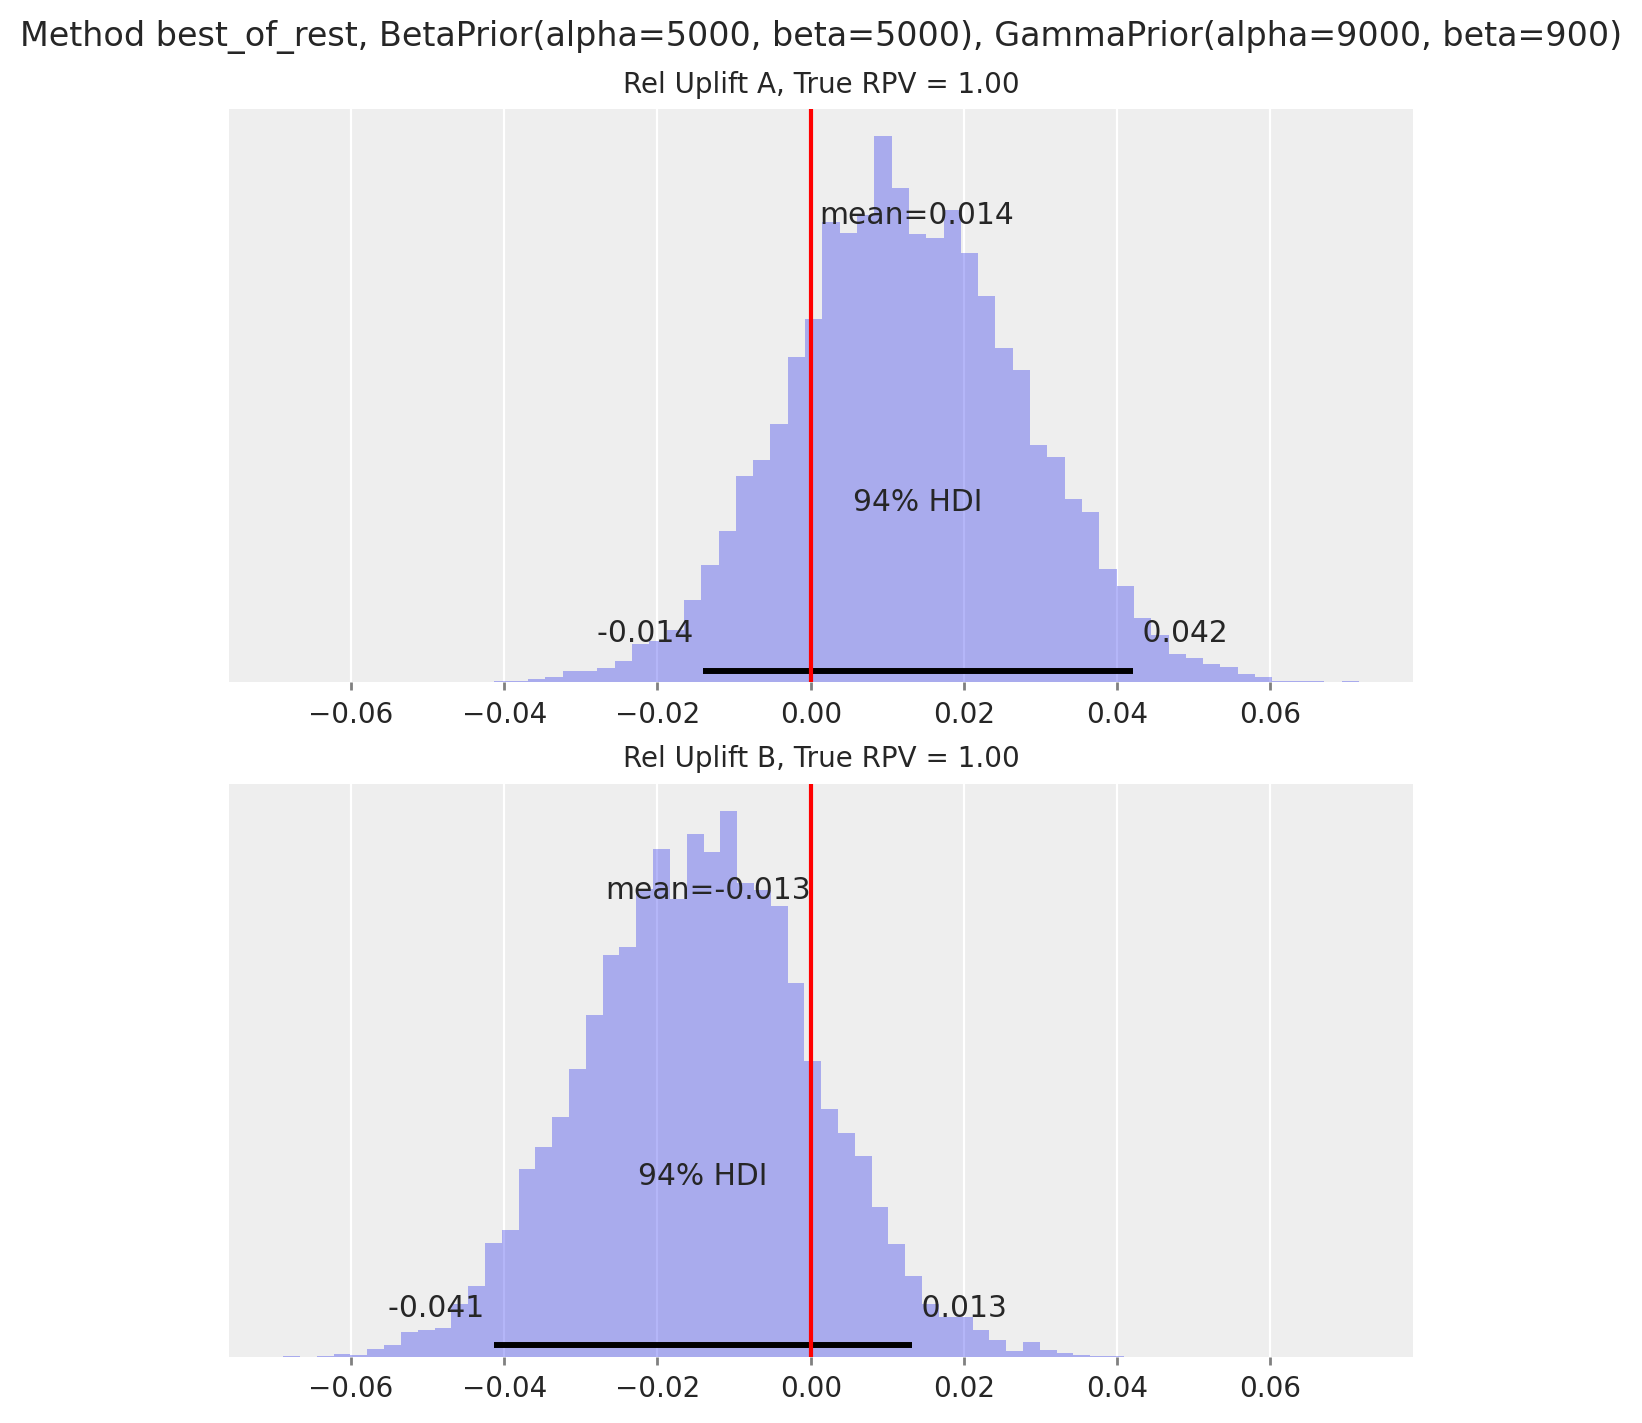

In [13]:
_ = run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.1, 0.1],
    true_mean_purchase=[10, 10],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=9000, beta=900),
    comparison_method="best_of_rest",
)

Inference: 
* the 94% HDI contains 0 as expected

## Scenario 2: Low Purhcase Rate and high Mean Purchase

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, lam]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


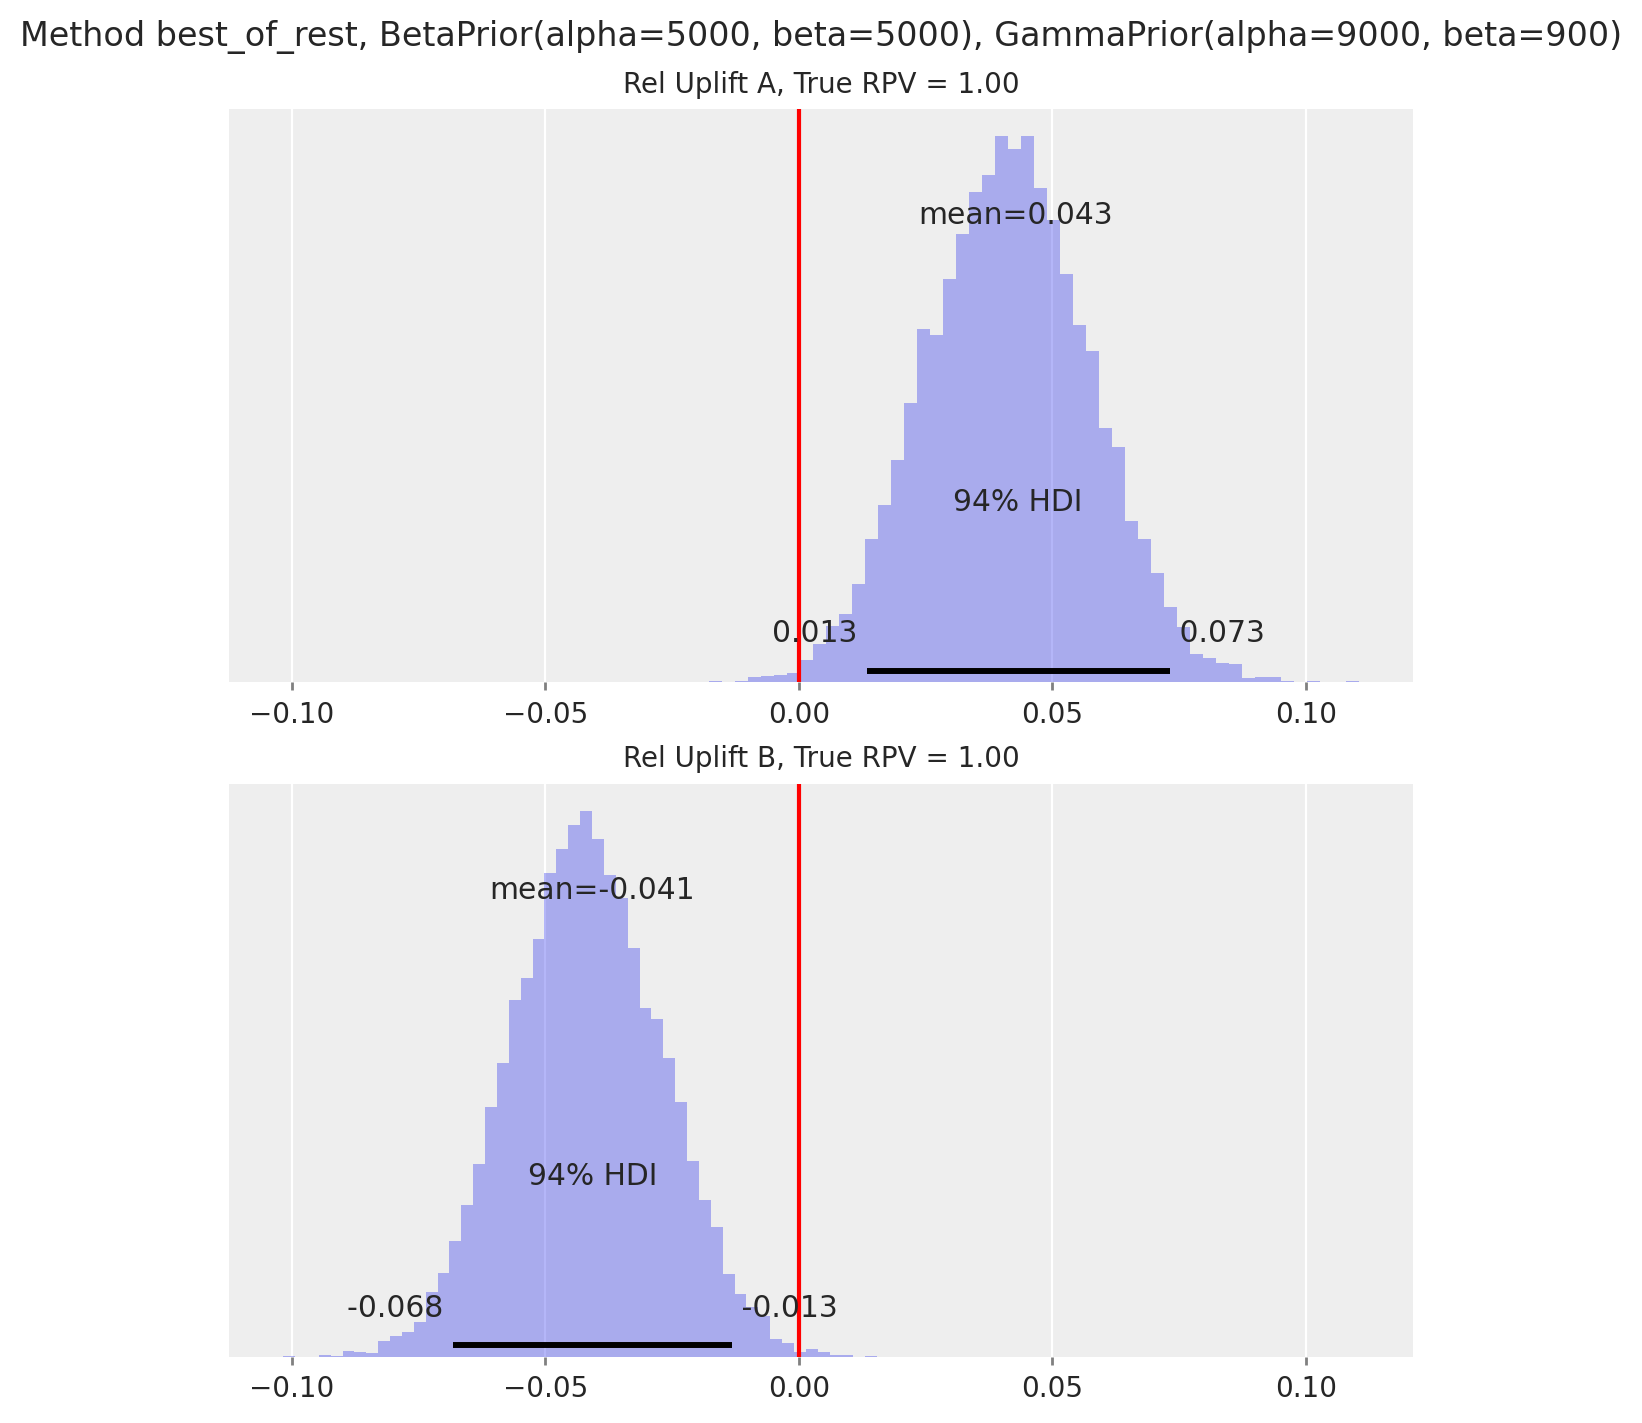

In [14]:
scenario_value_2 = run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.1, 0.08],
    true_mean_purchase=[10, 12.5],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=9000, beta=900),
    comparison_method="best_of_rest",
)

Inference:
* the 94% HDI for the average revenue per visitor contains 0 as expected
* In these cases, it is also useful to plot distributions for theta (purchase anything rate) and 1/lambda (the mean purchase value) to understand how the A/B test has affected visitor behavior. 

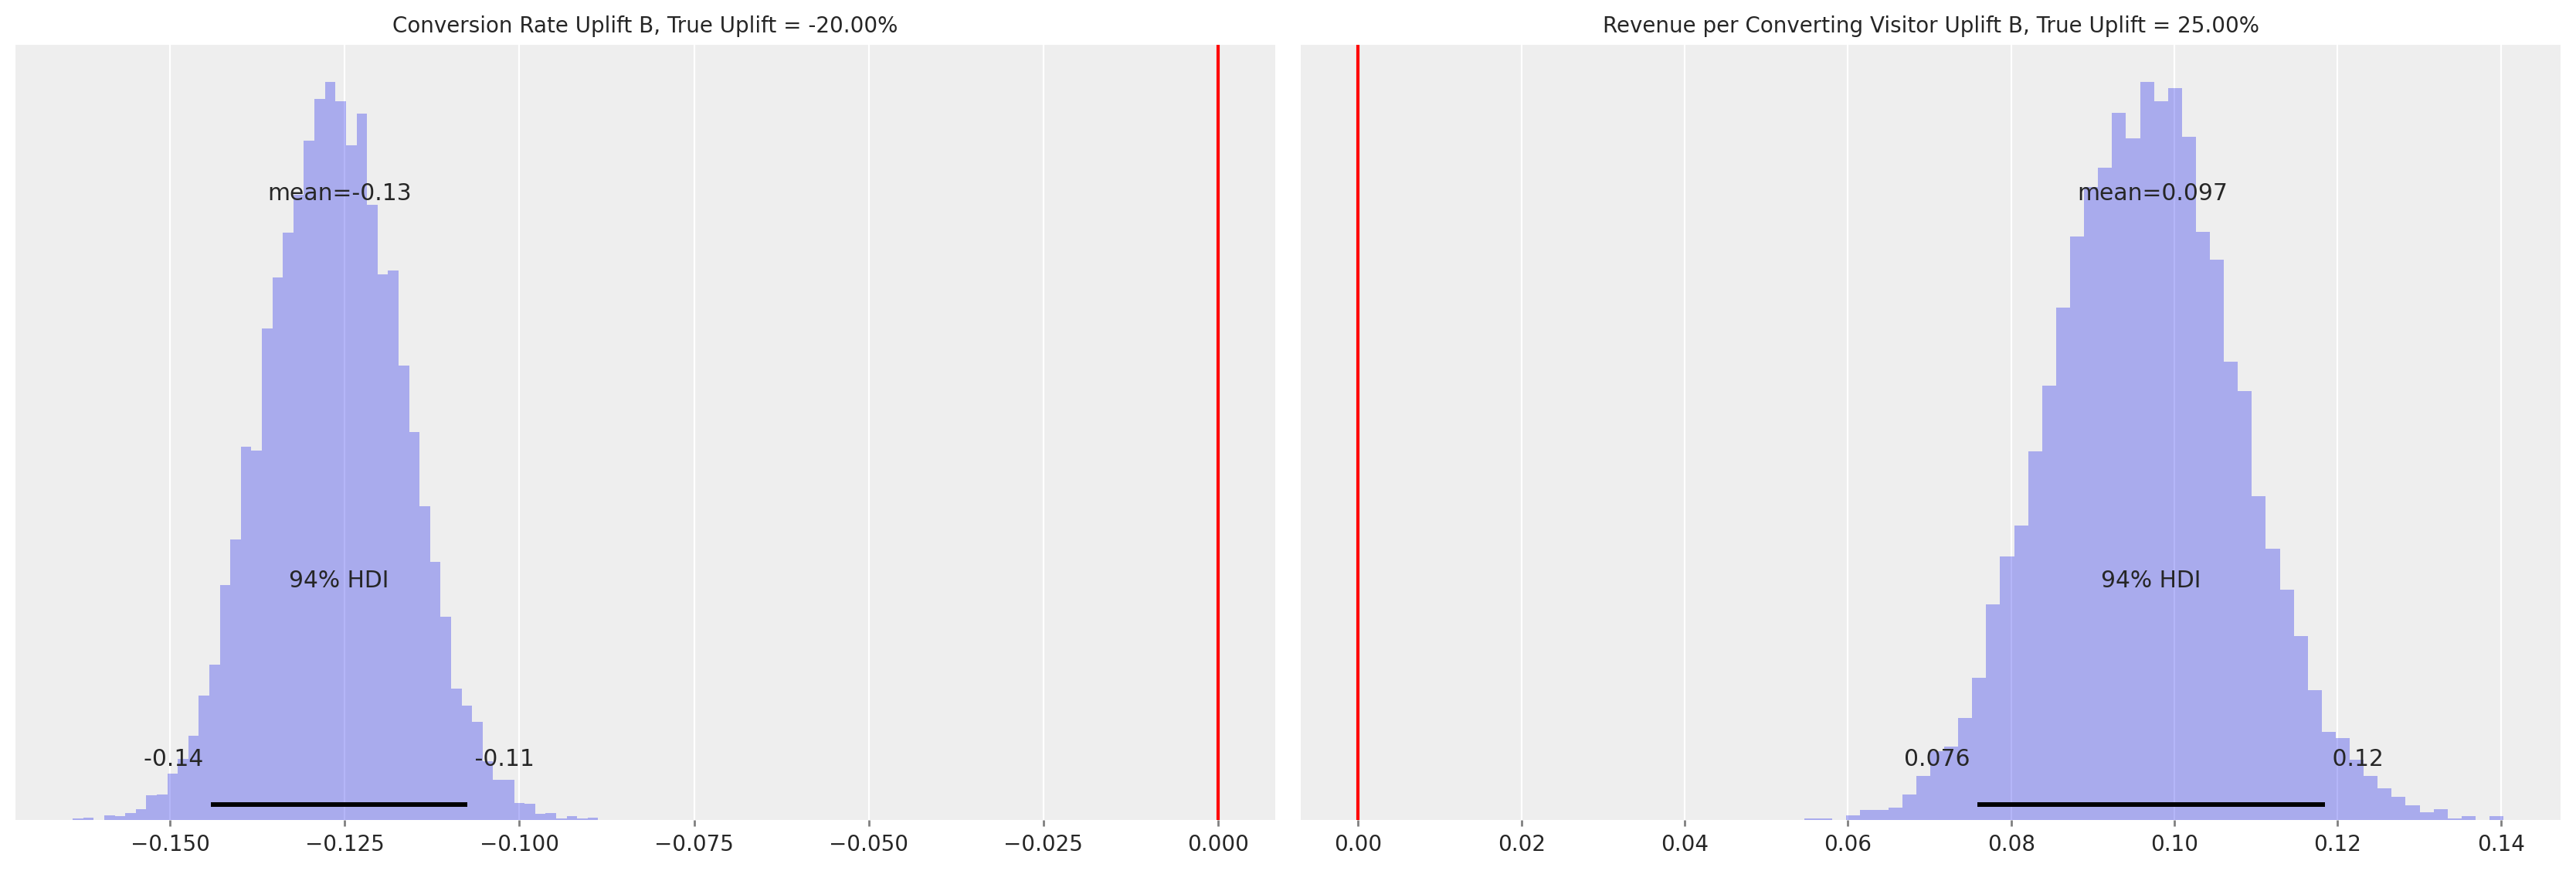

In [15]:
axs = az.plot_posterior(
    scenario_value_2,
    var_names=["theta_reluplift_1", "reciprocal_lam_reluplift_1"],
    **plotting_defaults,
)
axs[0].set_title(f"Conversion Rate Uplift B, True Uplift = {(0.04 / 0.05 - 1):.2%}", fontsize=10)
axs[0].axvline(x=0, color="red")
axs[1].set_title(
    f"Revenue per Converting Visitor Uplift B, True Uplift = {(25 / 20 - 1):.2%}", fontsize=10
)
axs[1].axvline(x=0, color="red");

Inference:
* Variant B's conversion rate uplift has a HDI well below 0, while the revenue per converting visitors has a HDI well above 0, so the model is able to capture the reduction in purchasing visitors as well as increase in the mean purchase amount.

## Scenario 3: Higher propernsity to purchase and mean purchase value

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, lam]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


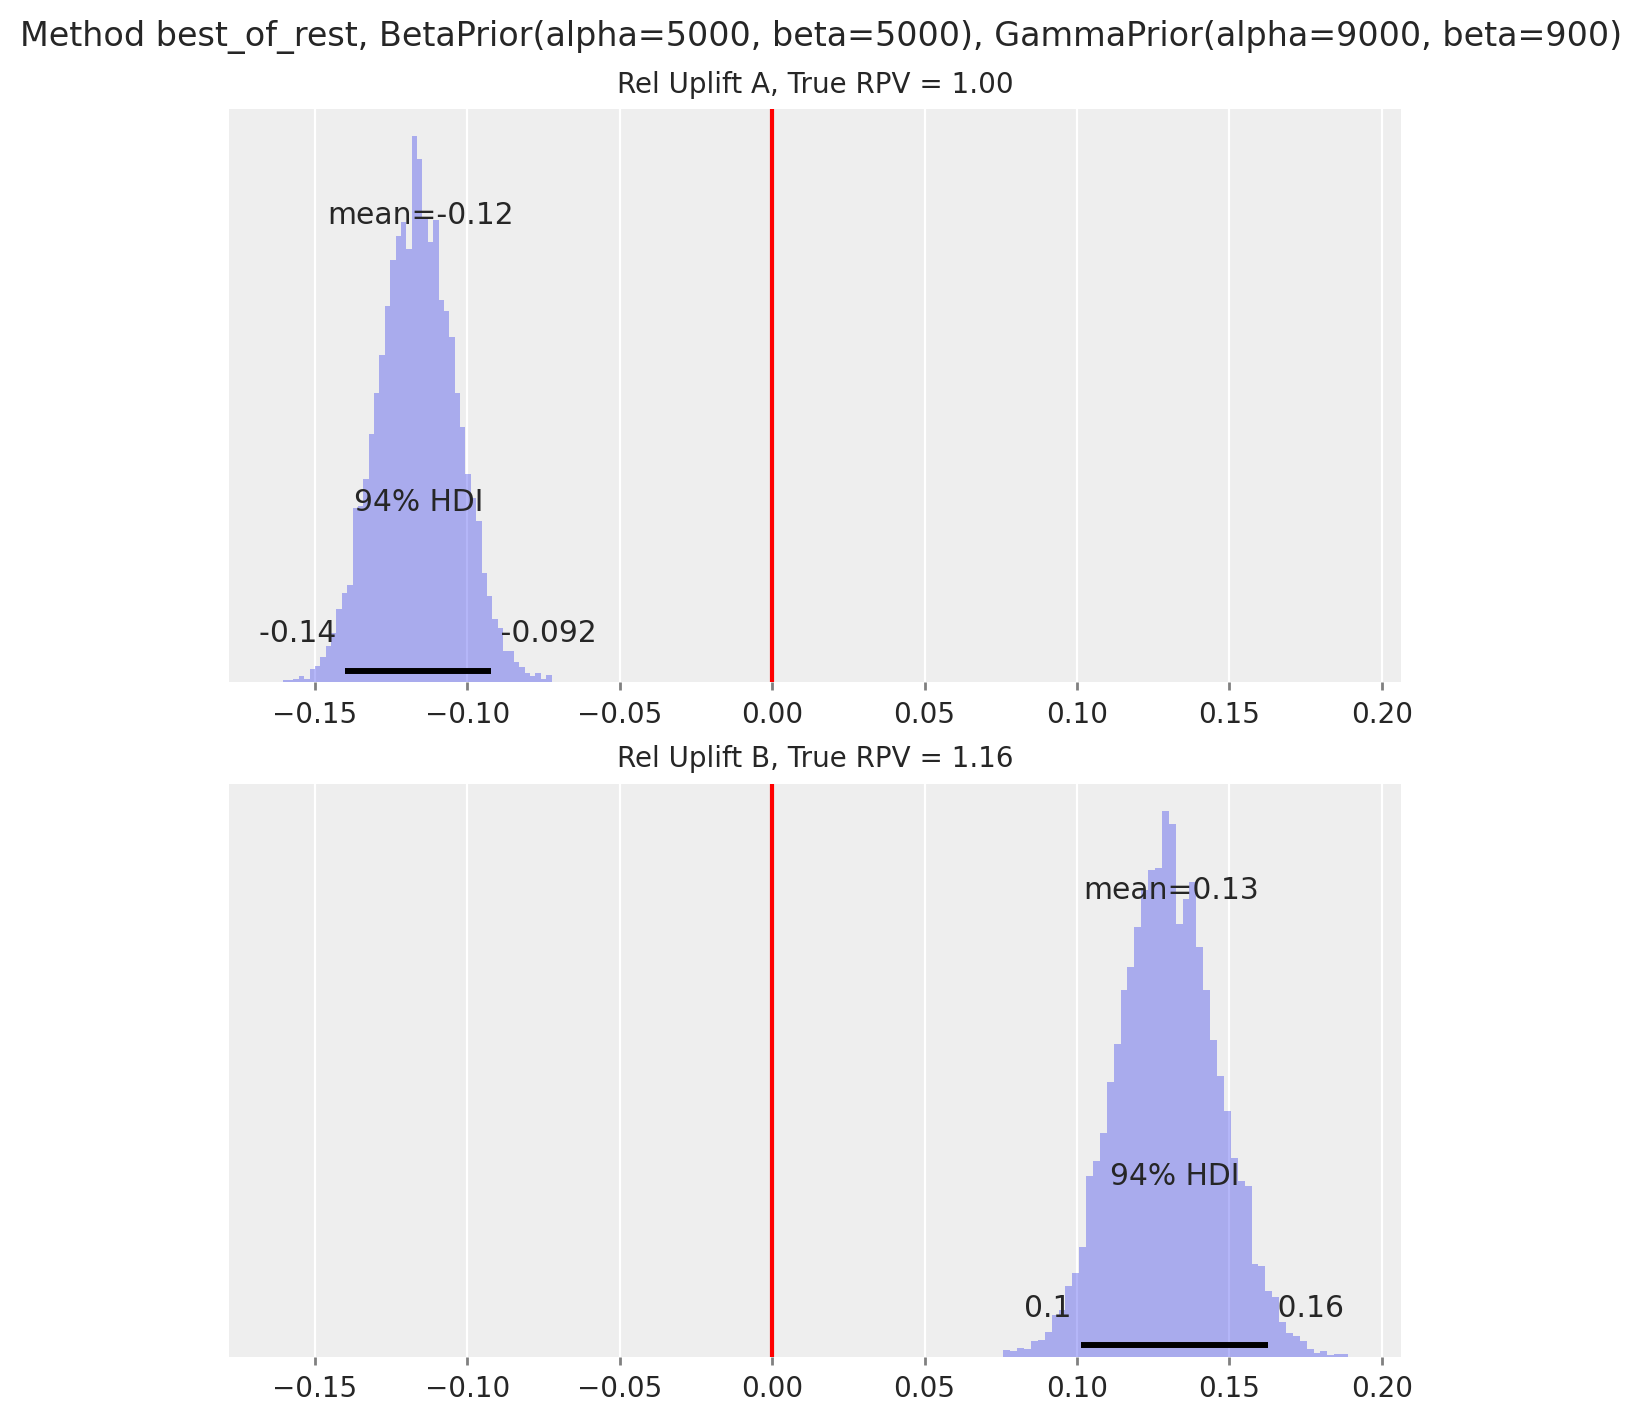

In [16]:
_ = run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.1, 0.11],
    true_mean_purchase=[10, 10.5],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=9000, beta=900),
    comparison_method="best_of_rest",
)

Inference: 
* We can observe that the relative uplift of B is greater than 0, hence is it is statistically significant


## References:
https://www.pymc.io/projects/examples/en/latest/case_studies/bayesian_ab_testing_introduction.html#value-conversions
